In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
import folium

from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import seaborn as sns
from sklearn.cluster import KMeans
import dtale # data Frame visualization
import datetime   # handle date times
import re         # regular expression package

# Load Data

Load data and select columns, and filter data

In [2]:
# Check if data has been pickled and if so load pickle
if os.path.exists('data/txDF.pkl') :
    txDF=pd.read_pickle('data/txDF.pkl',compression='gzip')
    tx_metro_cities_df = pd.read_pickle('data/tx_metro_cities.pkl',compression='gzip')    
    full_df = pd.read_pickle('data/FullDF.pkl',compression='gzip')    
else:
# pickle only the attributes we are interested in, and compress
# pickle is much faster to load / smaller than csv
    full_df = pd.read_csv('data/US_Accidents_Dec19.csv',encoding='utf-8')
    columns_of_interest=[
        'ID','Severity','Start_Time','End_Time','Start_Lat', 'Start_Lng', 'City', 
        'County', 'State','Zipcode', 'Country','Visibility(mi)', 
        'Weather_Condition','Precipitation(in)','Sunrise_Sunset','Civil_Twilight'
    ]
    condition=full_df['State'] =='TX'
    txDF=full_df[condition][columns_of_interest]
    txDF['Counter']=1
    #create df for selected cities 
    tx_metro_cities =  ['Austin', 'Round Rock', 'Cedar Park',
                 'San Marcos', 'Georgetown', 'Pflugerville',
                 'Hutto', 'Buda', 'Kyle', 'Leander',
                 'Dallas', 'Fort Worth', 'Arlington', 
                 'Plano','Garland', 'Irving', 'McKinney', 
                 'Frisco','Denton','Richardson', 'Allen','El Paso',
                 'Houston', 'The Woodlands', 'Sugar Land',
                 'Baytown', 'Conroe','San Antonio', 'New Braunfels', 
                 'Schertz', 'Seguin']
    condition = txDF['City'].isin(tx_metro_cities)
    
    tx_metro_cities_df = txDF[condition]    
    txDF.to_pickle("data/txDF.pkl",compression='gzip')
    tx_metro_cities_df.to_pickle("data/tx_metro_cities.pkl",compression='gzip')
    full_df.to_pickle("data/FullDF.pkl",compression='gzip')

# Number of Accidents by geography


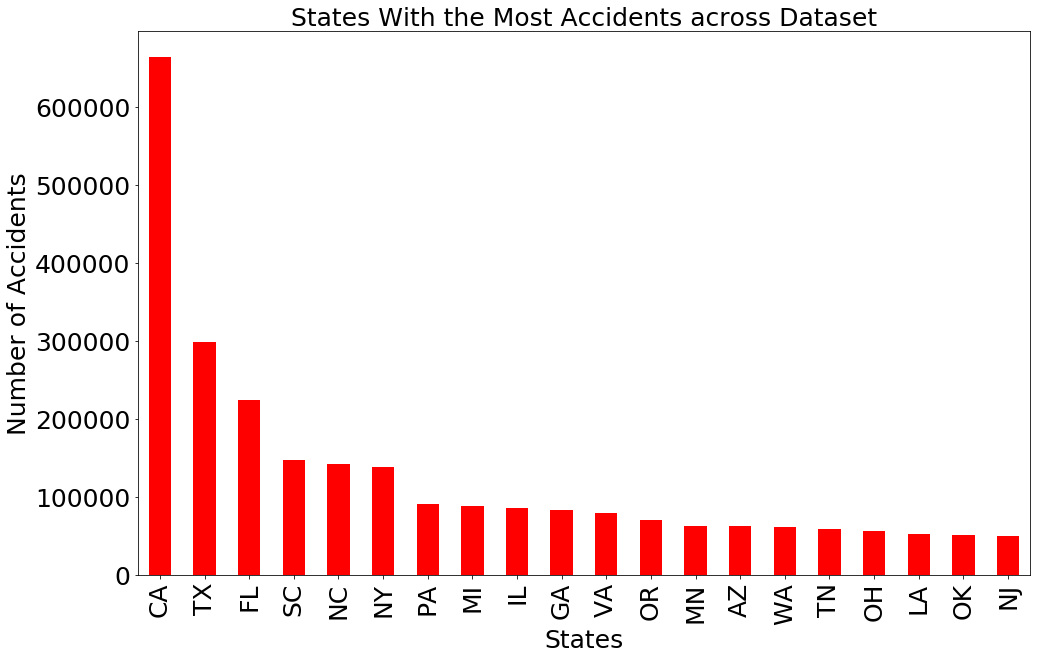

In [3]:
fig,ax = plt.subplots(figsize=(16,10))
axes=number_accident_vs_weather= full_df["State"].value_counts().head(20).plot.bar(color="red")
axes.set_ylabel("Number of Accidents", fontsize=25)
axes.set_xlabel("States", fontsize=25)
axes.set_title("States With the Most Accidents across Dataset", fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.savefig("output/States_With_Most_Accidents.png")

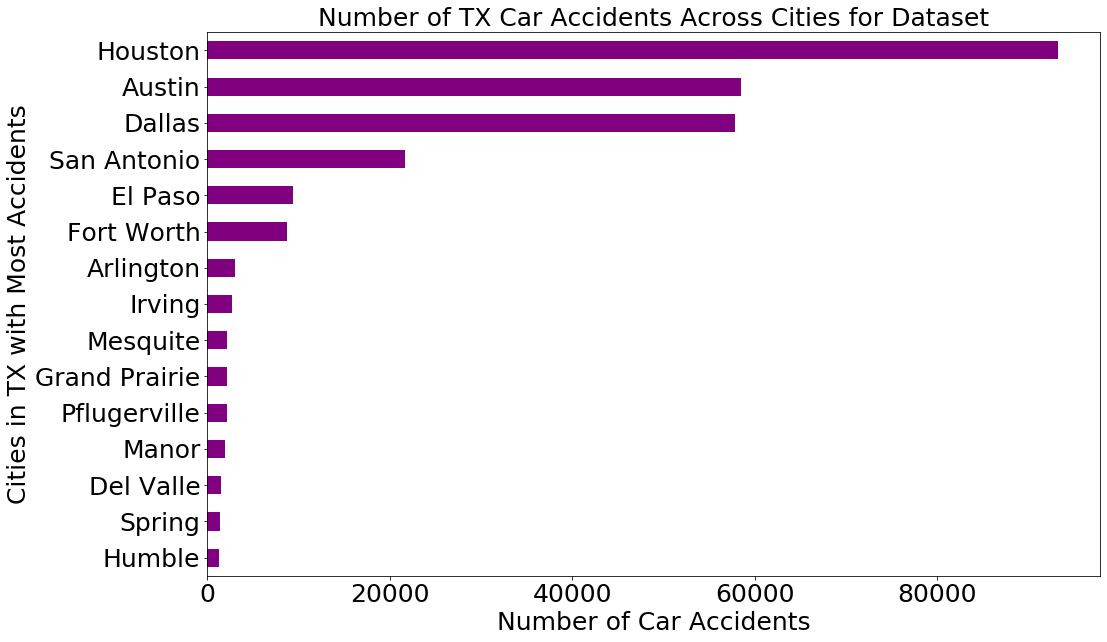

In [4]:
#create df for total counts of accidents across cities 
total_accident_data = txDF.groupby('City')['ID'].count().sort_values().tail(15)
fig,ax = plt.subplots(figsize=(16,10))
total_accident_data.plot(kind="barh", color="purple")
plt.title("Number of TX Car Accidents Across Cities for Dataset",fontsize=25)
plt.xlabel("Number of Car Accidents", fontsize=25)
plt.ylabel("Cities in TX with Most Accidents", fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.savefig("output/Num_Tx_Accidents_By_City.png")

9


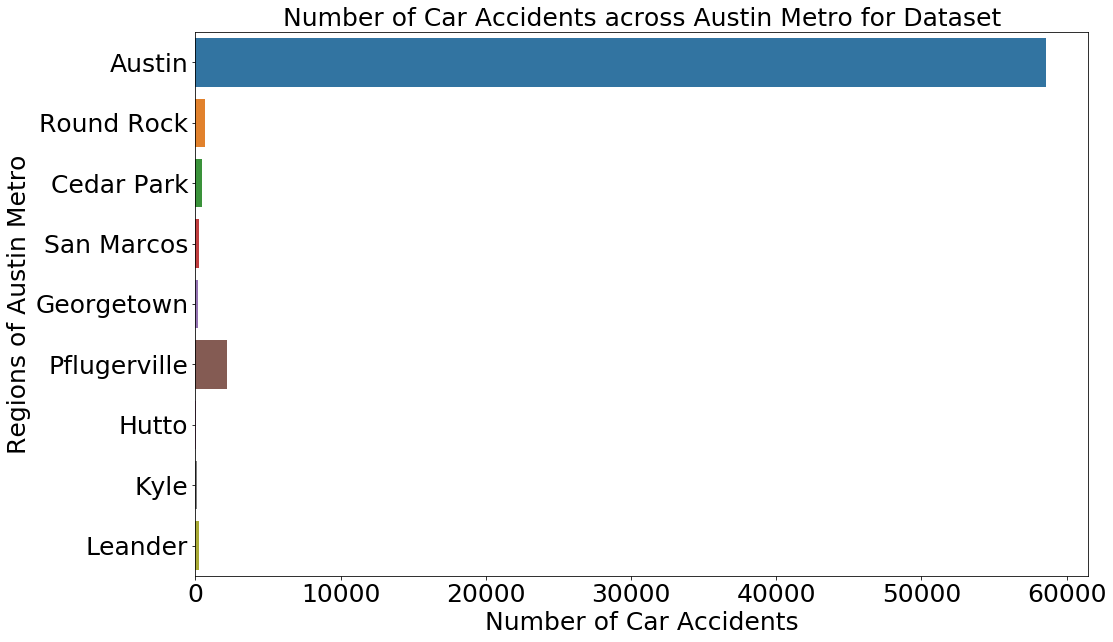

In [5]:
cities =  ['Austin', 'Round Rock', 'Cedar Park',
           'San Marcos', 'Georgetown', 'Pflugerville',
           'Hutto',  'Kyle', 'Leander']
print(len(cities))
countbyCity=[]
for i in cities:
    countbyCity.append(tx_metro_cities_df[tx_metro_cities_df['City']==i].count()['ID'])

fig,ax = plt.subplots(figsize=(16,10))
austin_metro=sns.barplot(countbyCity,cities)
austin_metro.set_title("Number of Car Accidents across Austin Metro for Dataset", fontsize=25)
austin_metro.set_xlabel("Number of Car Accidents", fontsize=25)
austin_metro.set_ylabel("Regions of Austin Metro", fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.savefig("output/Num_Austin_Accidents_By_Region.png")

# Date Attributes

Separate the *start_time* attribute into it several date components


In [6]:
# code fron fast ai
# Date Feature Engineering
# will split data colum in to corresponding 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear'
def add_datepart(df, fldname, drop=True,time=False):
    fld = df[fldname]
    attributes = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear']
    if time: attributes = attributes + ['Hour', 'Minute', 'Second']
    #, 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in attributes:
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [7]:
add_datepart(tx_metro_cities_df,'Start_Time',False,True )
tx_metro_cities_df.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'City', 'County', 'State', 'Zipcode', 'Country', 'Visibility(mi)',
       'Weather_Condition', 'Precipitation(in)', 'Sunrise_Sunset',
       'Civil_Twilight', 'Counter', 'Start_TimeYear', 'Start_TimeMonth',
       'Start_TimeWeek', 'Start_TimeDay', 'Start_TimeDayofweek',
       'Start_TimeDayofyear', 'Start_TimeHour', 'Start_TimeMinute',
       'Start_TimeSecond', 'Start_TimeElapsed'],
      dtype='object')

In [8]:
def dow(df):
    days=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    return days[df]
    

tx_metro_cities_df['Start_TimeDayofweek'] =tx_metro_cities_df['Start_TimeDayofweek'].apply(dow)

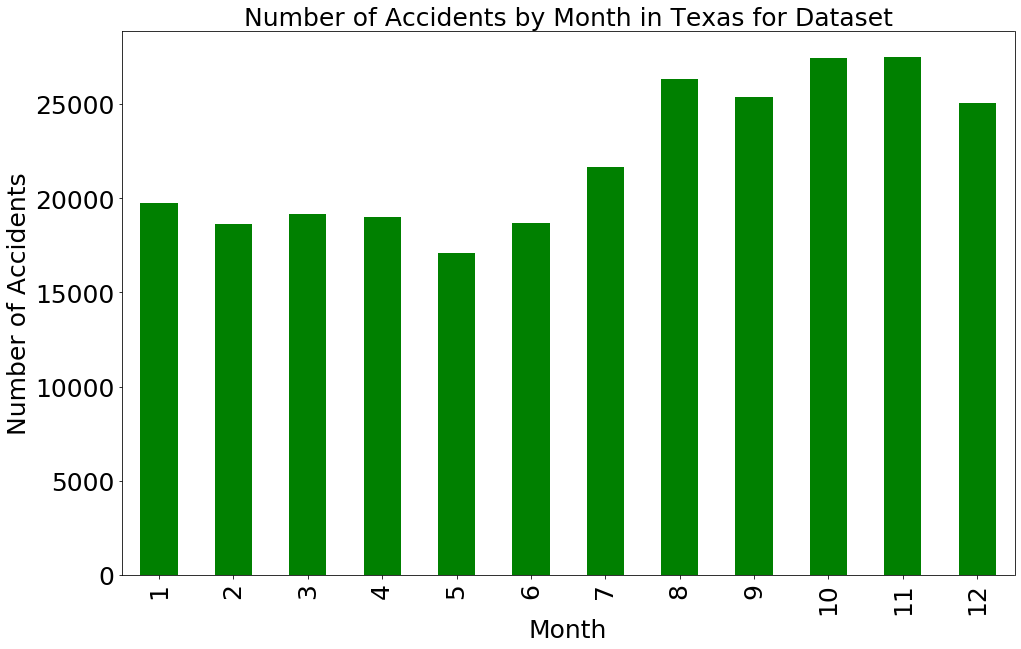

In [9]:
fig, ax = plt.subplots(figsize=(16,10))

tx_metro_cities_df.groupby(['Start_TimeMonth'])['Counter'].sum().plot(kind='bar', ax=ax, color = 'green')
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.title("Number of Accidents by Month in Texas for Dataset", fontsize=25)
plt.xlabel("Month", fontsize=25)
plt.ylabel("Number of Accidents", fontsize=25)
plt.savefig("output/Num_TX_Accidents_By_Month.png")

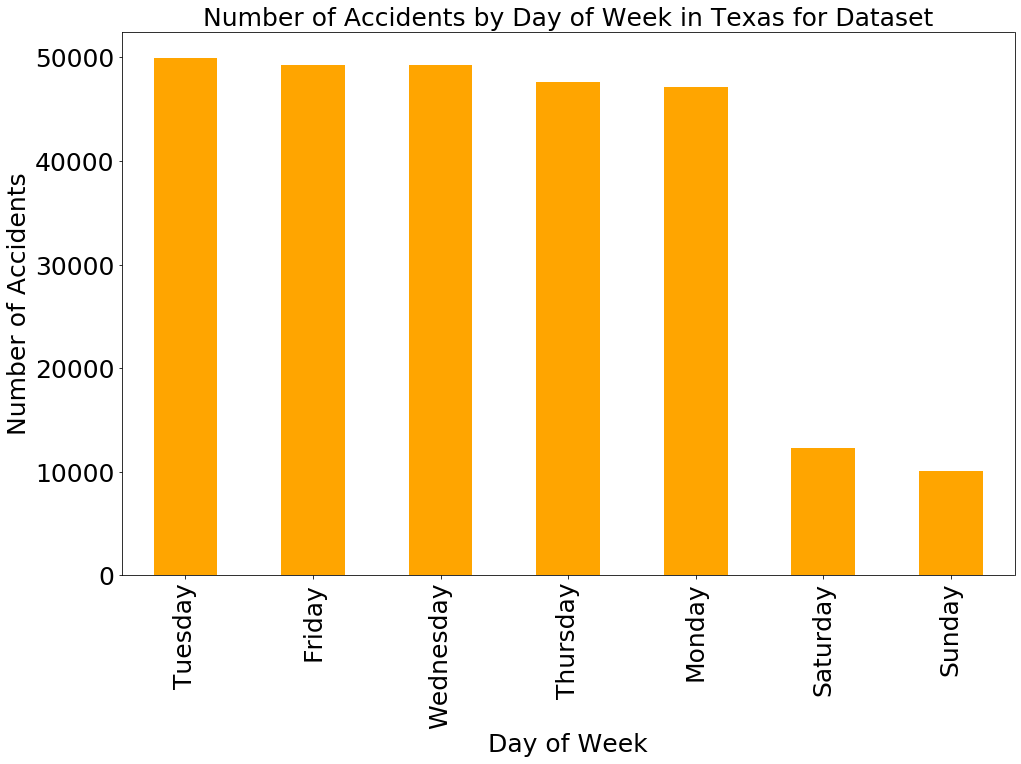

In [10]:
fig, ax = plt.subplots(figsize=(16,10))
tx_metro_cities_df['Start_TimeDayofweek'].value_counts().plot(kind='bar', ax=ax, color="orange")
plt.title("Number of Accidents by Day of Week in Texas for Dataset", fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.xlabel("Day of Week", fontsize=25)
plt.ylabel("Number of Accidents", fontsize=25)
plt.savefig("output/Num_TX_Accidents_By_Day_Week.png")

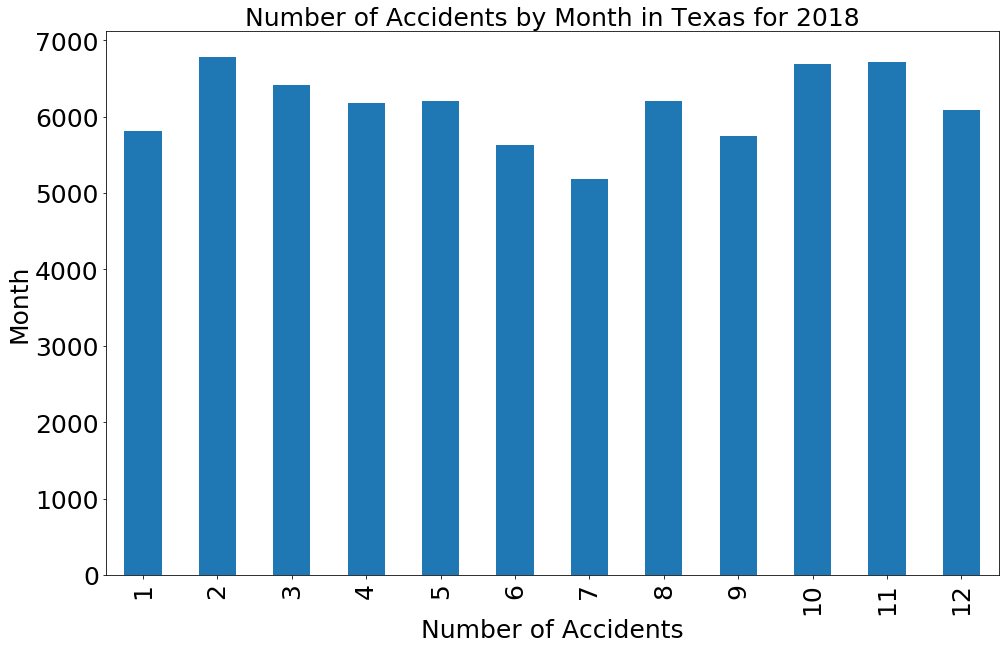

In [11]:
fig, ax = plt.subplots(figsize=(16,10))
condition = tx_metro_cities_df['Start_TimeYear'] == 2018
tx_metro_cities_df[condition].groupby(['Start_TimeMonth'])['ID'].count().plot(kind='bar')
plt.title("Number of Accidents by Month in Texas for 2018", fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.xlabel("Number of Accidents", fontsize=25)
plt.ylabel("Month", fontsize=25)
plt.savefig("output/Num_TX_Accidents_By_Month_2018.png")

In [12]:
def plot_map1(df,LatLong, city=None):
    accident_map = folium.Map(location=LatLong, 
#                           tiles = "Stamen Toner",
                           tiles = "OpenStreetMap",                              
                           zoom_start = 7)
    if city != None:
        data_heatmap = df[df["City"] == city]
    else:
        data_heatmap = df.copy()
    data_heatmap = data_heatmap[['Start_Lat','Start_Lng']]
    data_heatmap = [[row['Start_Lat'],row['Start_Lng']] for index, row in data_heatmap.iterrows()]
    HeatMap(data_heatmap, radius=15).add_to(accident_map)
    return accident_map

## Weekday Accidents



In [13]:
weekdays = ["Monday","Tuesday","Wednesday","Thursday","Friday"]
weekenddays =["Saturday","Sunday"]

In [14]:
condition = (tx_metro_cities_df['Start_TimeYear'] == 2018)  & (tx_metro_cities_df['Start_TimeDayofweek'].isin(weekdays))
plot_map1(tx_metro_cities_df[condition],[30.2672,-97.7431])

In [15]:
condition = (tx_metro_cities_df['Start_TimeYear'] == 2018)  & (tx_metro_cities_df['Start_TimeDayofweek'].isin(weekenddays))
plot_map1(tx_metro_cities_df[condition],[30.2672,-97.7431])

# Accidents by Hour in Austin



In [16]:
condition = (tx_metro_cities_df['Start_TimeYear'] == 2018) & (tx_metro_cities_df['City'] == 'Austin')
vc = tx_metro_cities_df[condition]['Start_TimeDayofyear'].value_counts().head()
vc

51     101
345     99
341     97
288     90
299     89
Name: Start_TimeDayofyear, dtype: int64

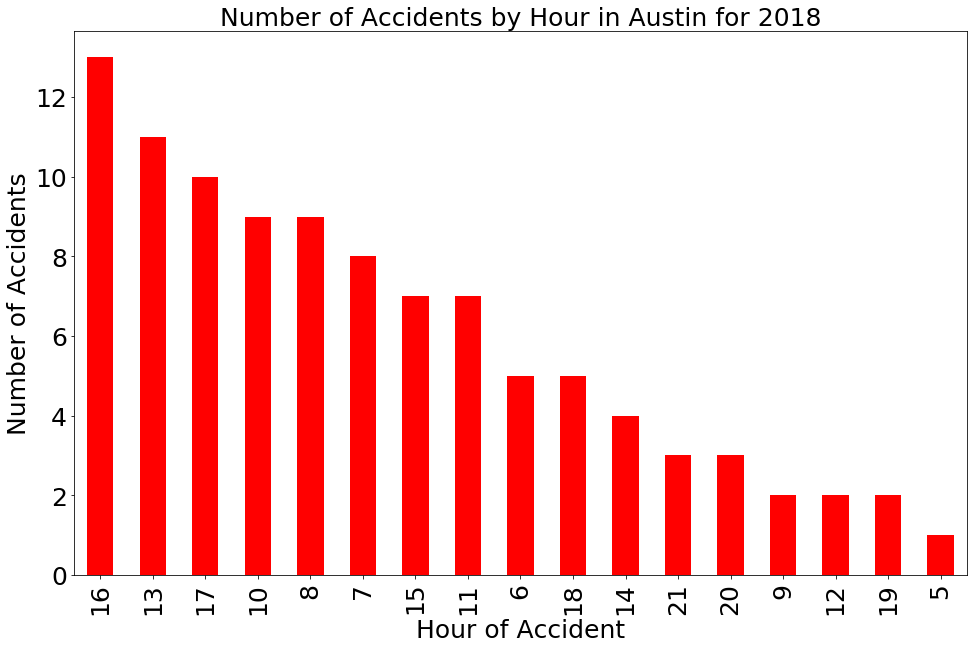

In [17]:
fig, ax = plt.subplots(figsize=(16,10))
condition = (tx_metro_cities_df['Start_TimeYear'] == 2018) & (tx_metro_cities_df['City'] == 'Austin') & (tx_metro_cities_df['Start_TimeDayofyear']==51)
tx_metro_cities_df[condition]['Start_TimeHour'].value_counts().plot(kind='bar', color="red")
plt.title("Number of Accidents by Hour in Austin for 2018", fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.xlabel("Hour of Accident", fontsize=25)
plt.ylabel("Number of Accidents", fontsize=25)
plt.savefig("output/Num_Austin_Accidents_By_Hour_2018.png")

Group times in ranges to 

* Morning Rush 6:00-9:59 AM
* Evening Rush 4:00-7:59 PM

In [18]:
timeBins = [0,5,9,13,16,19,24]
groupNames = ['<5','6-9','10-13','14-16','16-19','19-24']

tx_metro_cities_df['HourGroup']=pd.cut(tx_metro_cities_df['Start_TimeHour'],timeBins, labels=groupNames)


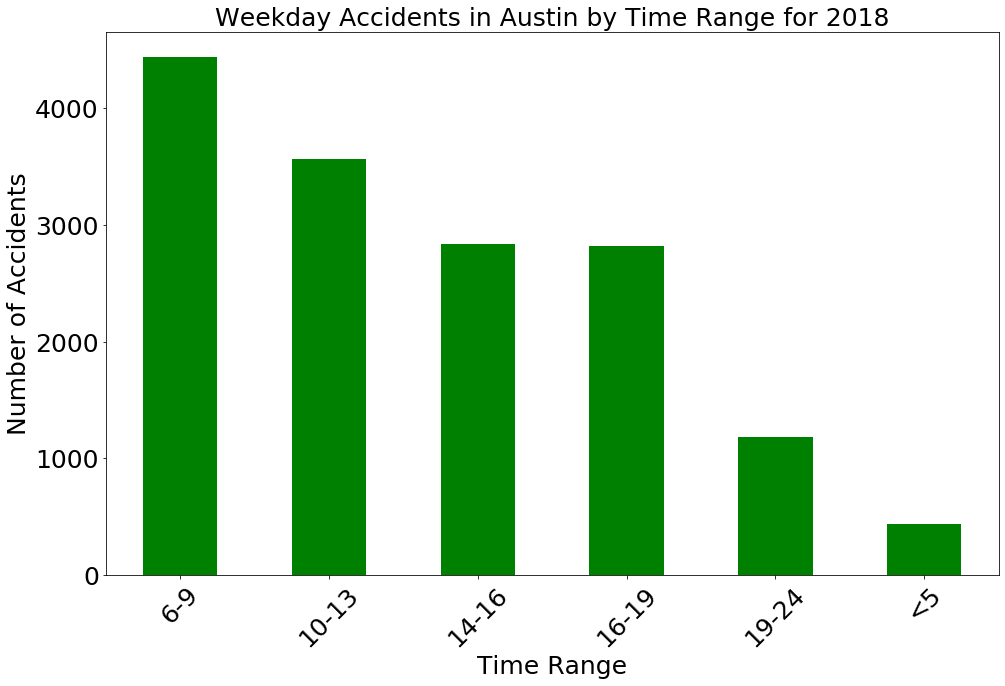

In [19]:
fig, ax = plt.subplots(figsize=(16,10))
condition = (tx_metro_cities_df['Start_TimeYear'] == 2018) & (tx_metro_cities_df['City'] == 'Austin')& (tx_metro_cities_df['Start_TimeDayofweek'].isin(weekdays)) 
tx_metro_cities_df[condition]['HourGroup'].value_counts().plot(kind='bar', ax=ax,rot=45, color="green")
plt.title("Weekday Accidents in Austin by Time Range for 2018", fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.xlabel("Time Range", fontsize=25)
plt.ylabel("Number of Accidents", fontsize=25)
plt.savefig("output/Num_Weekday_Austin_Accidents_2018.png")

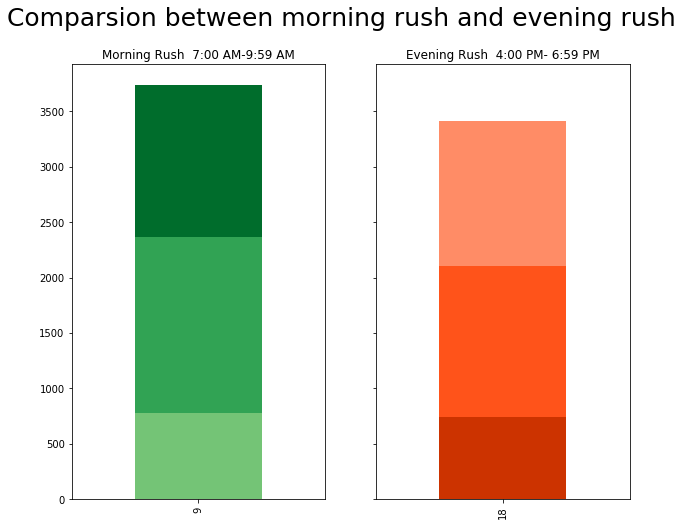

<Figure size 432x288 with 0 Axes>

In [20]:
types=['Morning Rush','Evening Rush']
morning_rush_hours=[7,8,9]
evening_rush_hour=[16,17,18]

condition = (tx_metro_cities_df['Start_TimeYear'] == 2018) & (tx_metro_cities_df['City'] == 'Austin')& (tx_metro_cities_df['Start_TimeDayofweek'].isin(weekdays)) 
df = tx_metro_cities_df[condition]

colors = ["#006D2C", "#31A354","#74C476"]
colors2 = ["#ff8c66", "#ff531a","#cc3300"]

fig, ((ax0),(ax1)) = plt.subplots(nrows=1,ncols=2,figsize=(10,8),sharey=True)  

margin_bottom = len(df[df['Start_TimeHour'].isin(morning_rush_hours)])


for num, val in enumerate(morning_rush_hours):
    condition =df['Start_TimeHour'] == val
    values = len(df[condition])
    margin_bottom -= values
    df[condition]['Start_TimeHour'] .value_counts().plot(kind='bar', ax=ax0,
                                     bottom = margin_bottom,color=colors[num],legend=False,title='Morning Rush  7:00 AM-9:59 AM')
   
 
margin_bottom= len(df[df['Start_TimeHour'].isin(evening_rush_hour)])

for num, val in enumerate(evening_rush_hour):
    condition =df['Start_TimeHour'] == val
    values = len(df[condition])
    margin_bottom -= values    
    df[condition]['Start_TimeHour'] .value_counts().plot(kind='bar', ax=ax1,
                                     bottom = margin_bottom,color=colors2[num],legend=False,title='Evening Rush  4:00 PM- 6:59 PM')
    

fig.suptitle('Comparsion between morning rush and evening rush', fontsize=25)

plt.show()
plt.savefig("output/Compare_Morning_Evening_Rush.png")

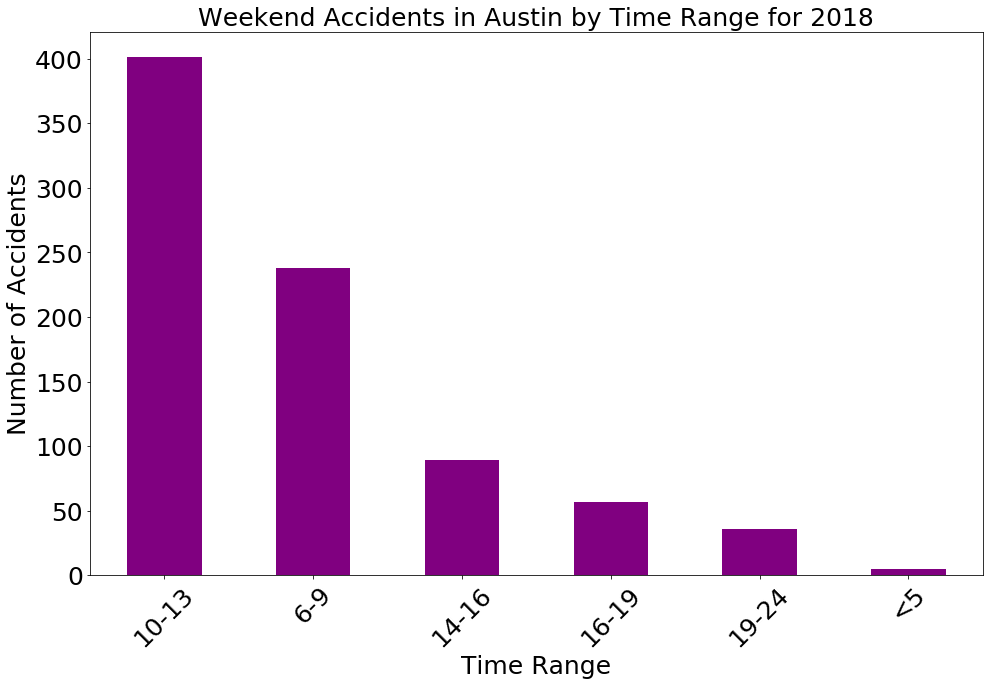

In [21]:
fig, ax = plt.subplots(figsize=(16,10))
condition = (tx_metro_cities_df['Start_TimeYear'] == 2018) & (tx_metro_cities_df['City'] == 'Austin')& (tx_metro_cities_df['Start_TimeDayofweek'].isin(weekenddays)) 
tx_metro_cities_df[condition]['HourGroup'].value_counts().plot(kind='bar', color="purple", rot=45)
plt.title("Weekend Accidents in Austin by Time Range for 2018", fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.xlabel("Time Range", fontsize=25)
plt.ylabel("Number of Accidents", fontsize=25)
plt.savefig("output/Num_Weekend_Austin_Accidents_2018.png")

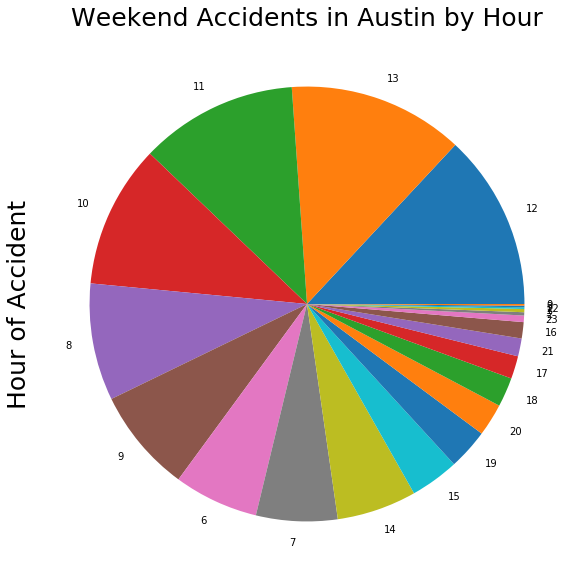

In [22]:
fig, ax = plt.subplots(figsize=(16,10))
tx_metro_cities_df[condition]['Start_TimeHour'].value_counts().plot(kind='pie')
plt.title("Weekend Accidents in Austin by Hour", fontsize=25)
plt.rcParams['font.size'] = 16
plt.ylabel("Hour of Accident", fontsize=25)
plt.savefig("output/Weekend_Austin_Accidents_By_Hour.png")

In [23]:
condition = (tx_metro_cities_df['Start_TimeYear'] == 2018) & (tx_metro_cities_df['City'] == 'Austin')  & (tx_metro_cities_df['Start_TimeDayofyear']==340)
onedf=tx_metro_cities_df[condition].sort_values('Start_TimeHour')

print(len(onedf))
import dtale
d= dtale.show(onedf,ignore_duplicate=True)
d

85


In [24]:
def plot_heatmapWithTime(df,LatLong, city=None):
    accident_map = folium.Map(location=LatLong, 
#                           tiles = "Stamen Toner",
                           tiles = "OpenStreetMap",                              
                           zoom_start = 10)
    if city != None:
        data_heatmap = df[df["City"] == city]
    else:
        data_heatmap = df.copy()

    daylist = []
    for day in data_heatmap.Start_TimeDayofyear.sort_values().unique():
        daylist.append(data_heatmap.loc[data_heatmap.Start_TimeDayofyear == day, ['Start_Lat','Start_Lng']].groupby(['Start_Lat', 'Start_Lng']).sum().reset_index().values.tolist())   
    print(len(daylist))
    HeatMapWithTime(daylist, auto_play=True, radius=10, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'},
                   min_opacity=0.4, max_opacity=0.6, use_local_extrema=False).add_to(accident_map)
   

    return accident_map

In [25]:
condition = (tx_metro_cities_df['Start_TimeYear'] == 2018)   & (txDF['City'] == 'Austin')
plot_heatmapWithTime(tx_metro_cities_df[condition],[30.2672,-97.7431])

/Users/neilhsu/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



360


In [26]:
condition = (tx_metro_cities_df['Start_TimeYear'] == 2018) & (tx_metro_cities_df['City'] == 'Austin') 
austinDF = tx_metro_cities_df[condition]

In [27]:
ausFatalityDF=pd.read_pickle('data/ausFatalityDF.pkl',compression='gzip')
ausFatalityDF.head()

type fatal_crash_number number_of_fatalities case_status  \
0  MOTOR VEHICLE                  1                    2      Closed   
1  MOTOR VEHICLE                  2                    1      Closed   
2     Motorcycle                  3                    1      Closed   
3  MOTOR VEHICLE                  4                    1      Closed   
4     Pedestrian                  5                    1        open   

  case_number               location area                     date month  day  \
0  18-0041689  5600 Block N IH 35 NB   ID  2018-01-04T00:00:00.000   Jan  Thu   
1  18-0160882    1500 W Slaughter Ln   FR  2018-01-16T00:00:00.000   Jan  Tue   
2  18-0241249    500 blk E Howard Ln   ED  2018-01-24T00:00:00.000   Jan  Wed   
3  18-0280382   3600 s mopac expy SB   DA  2018-01-28T00:00:00.000   Jan  Sun   
4  18-0301394  1650 E Anderson LN EB   ID  2018-01-30T00:00:00.000   Jan  Tue   

   ...    killed_driver_pass speeding ran_red_light_or_stop_sign  \
0  ...  driver and passenger        n                          n   
1  ...             passenger        n                          n   
2  ...              driver          n                         no   
3  ...                Driver        n                         no   
4  ...                   n/a        n                         no   

  dl_status_incident suspected_impairment restraint_type   type_of_road  \
0          suspended            driver           unknown           IH35   
1                 ok                 none  seatbelt worn  High Use Road   
2              no DL               Driver      no helmet          local   
3                 ok               Driver  seatbelt worn  Other Highway   
4                 ok                 none        unknown  Other Highway   

  failure_to_stop_and_render_aid     x_coord    y_coord  
0                              n   -97.70766  30.315355  
1                              n  -97.817994  30.173921  
2                              n  -97.654502  30.414118  
3                              n  -97.807409  30.245719  
4                            unk  -97.696643  30.337206  

[5 rows x 24 columns]

In [28]:
def plot_FatalityMap(df,LatLong, city=None):
    accident_map = folium.Map(location=LatLong, 
                           tiles = "OpenStreetMap",                              
                           zoom_start = 10)
    for lat,lan,name in zip(df['y_coord'],df['x_coord'],df['type']): 
        folium.Marker(location=[lat,lan],popup = name ,
                      icon= folium.Icon(color='red',icon = 'ambulance',prefix='fa')
                     ).add_to(accident_map)  

    return accident_map
plot_FatalityMap(ausFatalityDF,[30.2672,-97.7431])

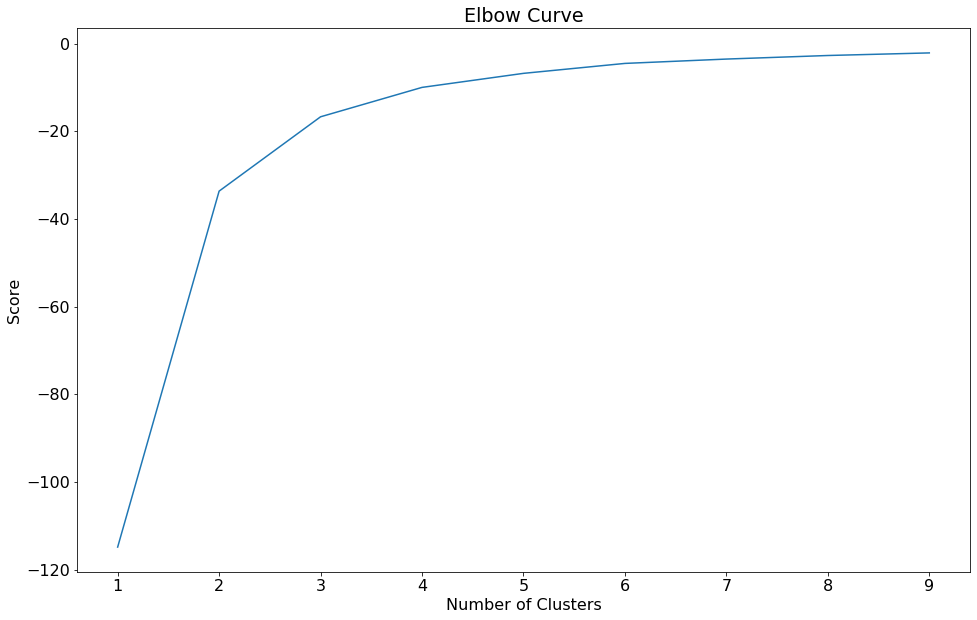

In [29]:
#condition = (austinDF['Start_TimeMonth'] == 12) 
#austinDFMonth = austinDF[condition]

#creating a variable that only has what we need: id, long, lat
austin_cluster=austinDF[["ID","Start_Lat", "Start_Lng"]]
austin_cluster.head(10)

#elbow method to validate the number of clusters 
K_clusters = range(1,10)
kmeans=[KMeans(n_clusters=i)for i in K_clusters]
Y_axis=austin_cluster[["Start_Lat"]]
X_axis=austin_cluster[["Start_Lng"]]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
#visualize
fig, ax = plt.subplots(figsize=(16,10))
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel("Score")
plt.title("Elbow Curve")
plt.show


def plot_ClusterMap(df,LatLong, city=None):
    accident_map = folium.Map(location=LatLong, 
#                           tiles = "Stamen Toner",
                           tiles = "OpenStreetMap",                              
                           zoom_start = 10)

    # Iterating over the LAT,LON,NAME and 
    # ELEV columns simultaneously using zip() 
    for lat,lan,name in zip(df['y_coord'],df['x_coord'],df['type']): 
    # Marker() takes location coordinates  
    # as a list as an argument 
        folium.Marker(location=[lat,lan],popup = name ).add_to(accident_map) 
                      #icon= folium.Icon(color=color(elev), 
                      #icon_color='yellow',icon = 'cloud')).add_to(accident_map) 

    return accident_map
#plot_FatalityMap(ausFatalityDF,[30.2672,-97.7431])
plt.savefig("output/Elbow_Curve.png")

In [30]:
#from above Elbow curve, we see that we only need 3 clusters
#determined where the graph begins to level off slowly 
kmeans=KMeans(n_clusters = 3, init = "k-means++")
#compute k-means clustering
kmeans.fit(austin_cluster[austin_cluster.columns[1:3]])
austin_cluster["Cluster_Label"]=kmeans.fit_predict(austin_cluster[austin_cluster.columns[1:3]])
#coordinates of cluster centers
centers = kmeans.cluster_centers_
#labels for each point
labels=kmeans.predict(austin_cluster[austin_cluster.columns[1:3]])
austin_cluster.head(20)
austin_cluster.shape

/Users/neilhsu/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(16103, 4)

In [31]:
def plot_ClusterMap(df,LatLong, city=None):
    accident_map = folium.Map(location=LatLong, 
                           tiles = "OpenStreetMap",                              
                           zoom_start = 9)
    colors = ['blue', 'green', 'red']
    for lat,lan,Cluster_Label in zip(df['Start_Lat'],df['Start_Lng'],df['Cluster_Label']): 
    # Marker() takes location coordinates  
    # as a list as an argument 
        folium.Marker(location=[lat,lan],popup = Cluster_Label,
                      icon= folium.Icon(color=colors[Cluster_Label],icon = 'car',prefix='fa')
                     ).add_to(accident_map) 
                      

    return accident_map
plot_ClusterMap(austin_cluster.sample(500),[30.2672,-97.7431])